In [1]:
import pandas as pd

# Load raw CSV (with inconsistent commas)
df_raw = pd.read_csv("amazon_cells_labelled.csv", header=None)

# Function to extract label from any of the extra columns
def extract_label(row):
    for val in row[1:]:
        if str(val).strip() in ['0', '1']:
            return int(val)
    return None

# Step 1: Extract review text and label
df_clean = pd.DataFrame()
df_clean['text'] = df_raw[0]                      # first column is the review
df_clean['label'] = df_raw.apply(extract_label, axis=1)

# Step 2: Drop rows with missing labels
df_clean = df_clean.dropna().reset_index(drop=True)
df_clean['label'] = df_clean['label'].astype(int)

# Step 3 (Optional): Check basic stats
print("Sample data:")
print(df_clean.head())
print("\nLabel distribution:")
print(df_clean['label'].value_counts())

# Step 4: Save cleaned dataset
df_clean.to_csv("cleaned_amazon_sentiment.csv", index=False)

print("\n✅ Cleaned dataset saved as 'cleaned_amazon_sentiment.csv'")


Sample data:
                                                text  label
0  So there is no way for me to plug it in here i...      0
1                                          Good case      1
2                             Great for the jawbone.      1
3  Tied to charger for conversations lasting more...      0
4                                  The mic is great.      1

Label distribution:
label
0    499
1    497
Name: count, dtype: int64

✅ Cleaned dataset saved as 'cleaned_amazon_sentiment.csv'


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        92
           1       0.87      0.77      0.82       108

    accuracy                           0.81       200
   macro avg       0.82      0.82      0.81       200
weighted avg       0.82      0.81      0.82       200



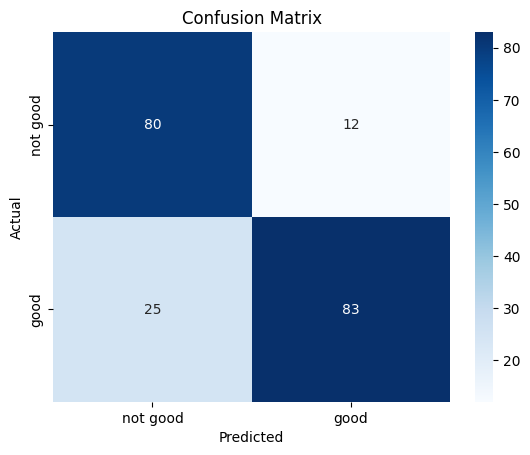

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load cleaned dataset
df = pd.read_csv("cleaned_amazon_sentiment.csv")

# Step 1: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=42
)

# Step 2: TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

# Step 3: Train Logistic Regression
clf = LogisticRegression()
clf.fit(X_train_vec, y_train)

# Step 4: Predictions and Evaluation
y_pred = clf.predict(X_test_vec)

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["not good", "good"], yticklabels=["not good", "good"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [5]:
import pandas as pd
import requests
import json
from sklearn.metrics import classification_report

# Load cleaned dataset
df = pd.read_csv("cleaned_amazon_sentiment.csv")

# Reduce to 50 examples for speed (optional)
df_sample = df.sample(n=100, random_state=42).reset_index(drop=True)

# Function to query Ollama
def query_ollama(prompt, model="llama2"):
    url = "http://localhost:11434/api/generate"
    payload = {
        "model": model,
        "prompt": prompt,
        "stream": False
    }
    response = requests.post(url, data=json.dumps(payload))
    result = response.json()
    return result["response"].strip().lower()

# Predict using LLaMA
llama_preds = []
for text in df_sample["text"]:
    prompt = f'Classify the sentiment as "good" or "not good": "{text}"'
    result = query_ollama(prompt)
    if "not good" in result:
        llama_preds.append(0)
    elif "good" in result:
        llama_preds.append(1)
    else:
        llama_preds.append(-1)  # unknown or unclear

# Remove unclear predictions
df_sample["llama_pred"] = llama_preds
df_eval = df_sample[df_sample["llama_pred"] != -1]

# Evaluation
print("✅ Evaluation on", len(df_eval), "samples:")
print(classification_report(df_eval["label"], df_eval["llama_pred"]))


✅ Evaluation on 96 samples:
              precision    recall  f1-score   support

           0       1.00      0.79      0.88        43
           1       0.85      1.00      0.92        53

    accuracy                           0.91        96
   macro avg       0.93      0.90      0.90        96
weighted avg       0.92      0.91      0.90        96

